# K-means Cluster Heatmaps

In [33]:
import pandas as pd

expression = pd.read_csv("expression.txt", sep="\t")
expression = expression.set_index("Hugo_Symbol")
expression = expression.drop("Entrez_Gene_Id", axis=1)
print(expression.head())

             TCGA-2A-A8VL  TCGA-2A-A8VO  TCGA-2A-A8VT  TCGA-2A-A8VV  \
Hugo_Symbol                                                           
UBE2Q2P2          -0.0083       -0.2773        3.2620       -0.0837   
HMGB1P1               NaN           NaN           NaN           NaN   
LOC155060             NaN           NaN           NaN           NaN   
RNU12-2P              NaN           NaN           NaN           NaN   
SSX9              -0.0474       -0.0474       -0.0474       -0.0474   

             TCGA-2A-A8VX  TCGA-2A-A8W1  TCGA-2A-A8W3  TCGA-2A-AAYF  \
Hugo_Symbol                                                           
UBE2Q2P2          -0.6895        1.5382       -0.1466        0.3710   
HMGB1P1               NaN           NaN           NaN           NaN   
LOC155060             NaN           NaN           NaN           NaN   
RNU12-2P              NaN           NaN           NaN           NaN   
SSX9              -0.0474       -0.0474       -0.0474       -0.0474   

    

In [45]:
patients = pd.read_csv("patient_bchm_recurr_cohorts.csv")
print(patients.head())
print()
bchm_early_pts = patients[patients["Days to Bchm Recurr"]<100]
bchm_late_pts = patients[patients["Days to Bchm Recurr"]>100]
bchem_early_ids = bchm_early_pts["Patient (Firehose)"].to_list()
bchem_late_ids = bchm_late_pts["Patient (Firehose)"].to_list()
print(bchem_early_ids)
print()
print(bchem_late_ids)

  Patient (Firehose)  Days to Bchm Recurr Confirmed to have recurred
0       TCGA-EJ-5504                   77      1:Recurred/Progressed
1       TCGA-J4-AATZ                   79      1:Recurred/Progressed
2       TCGA-EJ-7783                   81      1:Recurred/Progressed
3       TCGA-EJ-5519                   84      1:Recurred/Progressed
4       TCGA-J9-A52B                   85      1:Recurred/Progressed

['TCGA-EJ-5504', 'TCGA-J4-AATZ', 'TCGA-EJ-7783', 'TCGA-EJ-5519', 'TCGA-J9-A52B', 'TCGA-V1-A9ZI', 'TCGA-VP-A878']

['TCGA-YL-A9WK', 'TCGA-KC-A4BR', 'TCGA-KK-A8IC', 'TCGA-YL-A8HO', 'TCGA-KK-A8I7', 'TCGA-KK-A7AY', 'TCGA-VP-A87D', 'TCGA-KK-A7AQ', 'TCGA-KC-A4BV', 'TCGA-G9-6498', 'TCGA-YL-A8HK', 'TCGA-YL-A8SI', 'TCGA-YL-A9WX', 'TCGA-G9-6339', 'TCGA-EJ-8469']


In [54]:
early_bchem = expression[expression.columns.intersection(bchem_early_ids)]
early_bchem = early_bchem.dropna(axis=0)
late_bchem = expression[expression.columns.intersection(bchem_late_ids)]
late_bchem = late_bchem.dropna(axis=0)
print(early_bchem.head())
print()
print(late_bchem.head())

             TCGA-EJ-5504  TCGA-EJ-5519  TCGA-EJ-7783  TCGA-J4-AATZ  \
Hugo_Symbol                                                           
UBE2Q2P2          -0.5443        0.0453       -0.0651        1.9077   
SSX9              -0.0474       -0.0474       -0.0474       -0.0474   
EZHIP             -0.0684       -0.5459       -0.2836       -0.7616   
EFCAB8            -0.4290       -0.1805       -0.4290        0.6982   
SDR16C6P          -0.1839       -0.1839       -0.1839       -0.1839   

             TCGA-J9-A52B  TCGA-V1-A9ZI  TCGA-VP-A878  
Hugo_Symbol                                            
UBE2Q2P2          -0.7704        0.0259        0.5946  
SSX9              -0.0474       -0.0474       -0.0474  
EZHIP             -0.3635        3.9888       -0.0951  
EFCAB8             0.2590        0.7438        0.3389  
SDR16C6P          -0.1839       -0.1839       -0.1839  

             TCGA-EJ-8469  TCGA-G9-6339  TCGA-G9-6498  TCGA-KC-A4BR  \
Hugo_Symbol                           

In [64]:
early_bchem["Early Average"] = early_bchem.mean(axis=1)
# print(early_bchem.head())
late_bchem["Late Average"] = late_bchem.mean(axis=1)
# print(late_bchem.head())
combined_df["Early Average"] = early_bchem[["Early Average"]] 
combined_df["Late Average"] = late_bchem[["Late Average"]] 
# combined_df = append(late_bchem[["Late Average"]]
print(combined_df.head())

             Early Average  Late Average
Hugo_Symbol                             
UBE2Q2P2          0.170529      0.499920
SSX9             -0.047400     -0.047400
EZHIP             0.267243      0.161573
EFCAB8            0.143057      0.141553
SDR16C6P         -0.183900     -0.183900


/tmp/ipykernel_1808/817388062.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df["Early Average"] = early_bchem[["Early Average"]]
/tmp/ipykernel_1808/817388062.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df["Late Average"] = late_bchem[["Late Average"]]


In [65]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram

expression = combined_df

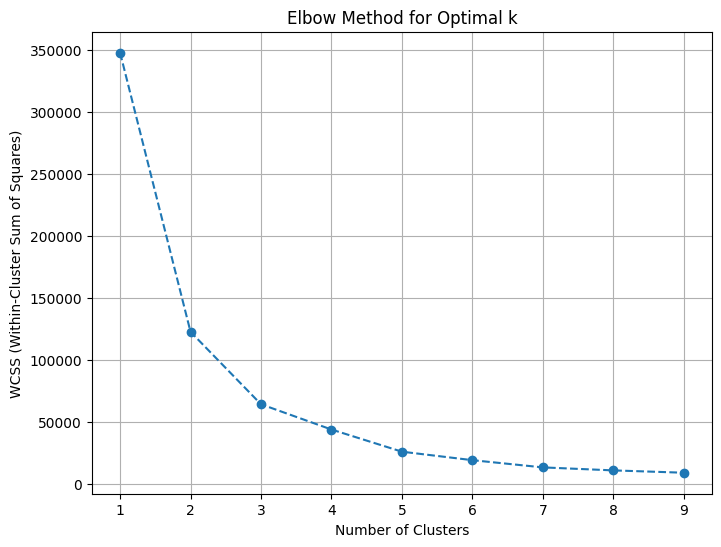

In [68]:
data = expression

# List to store WCSS for each number of clusters
wcss = []

# Loop over possible values of k (number of clusters)
for num_clusters in range(1, 10):  # You can adjust the range based on your data
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)  # WCSS is stored in inertia_

# Plot the Elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, 10), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.xticks(np.arange(1, 10))
plt.grid(True)
plt.show()

/tmp/ipykernel_1808/2521359146.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Cluster"] = clusters
/tmp/ipykernel_1808/2521359146.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Cluster"] = data["Cluster"].map(cluster_mapping)


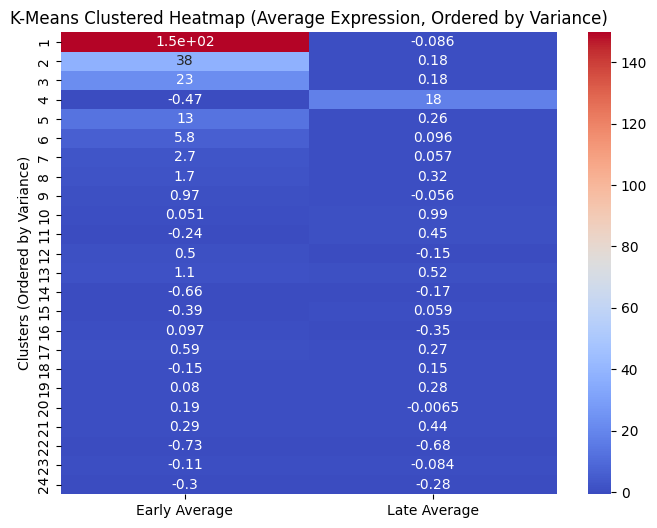

In [98]:
num_clusters = 24 # The rationale for 4! is that all possible combinations (ie. high, low, low, low) can be captured
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(data)
data["Cluster"] = clusters

clustered_data = data.groupby("Cluster").mean()

cluster_variances = clustered_data.var(axis=1)

# Sort clusters by variance (highest variance first) and reassign labels
sorted_clusters = cluster_variances.sort_values(ascending=False).index
cluster_mapping = {old: new for new, old in enumerate(sorted_clusters, start=1)}
data["Cluster"] = data["Cluster"].map(cluster_mapping)

clustered_data = clustered_data.loc[sorted_clusters]
clustered_data.index = [cluster_mapping[idx] for idx in clustered_data.index]

# Plot heatmap for averaged clusters
plt.figure(figsize=(8, 6))
sns.heatmap(clustered_data, cmap="coolwarm", xticklabels=True, yticklabels=True, annot=True)

plt.title("K-Means Clustered Heatmap (Average Expression, Ordered by Variance)")
plt.ylabel("Clusters (Ordered by Variance)")
plt.show()

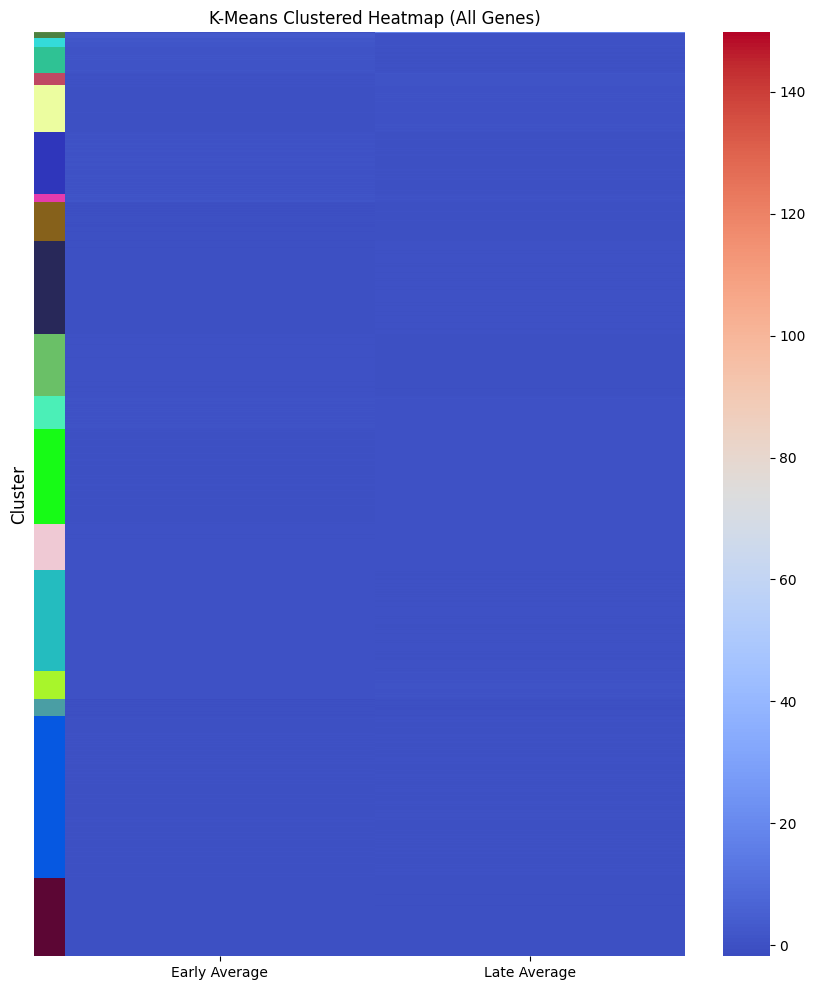

In [115]:
from matplotlib.colors import ListedColormap

# Reorder full dataset by new cluster labels
data_sorted = data.sort_values(by="Cluster")

# Get the number of unique clusters
num_clusters = data_sorted["Cluster"].nunique()

# Generate a random colormap for clusters
random_colors = np.random.rand(num_clusters, 3)  # Random RGB colors
cluster_cmap = ListedColormap(random_colors)  # Create colormap

# Create a figure for both heatmaps
plt.figure(figsize=(10, 12))

# Create a main heatmap for the data (without the cluster column)
sns.heatmap(data_sorted.drop(columns=["Cluster"]), cmap="coolwarm", xticklabels=True, yticklabels=False)

# Create an inset axis for the color bar (cluster labels)
cbar_ax = plt.gca().inset_axes([-0.05, 0, 0.05, 1])  # Thin vertical color bar on the left side

# Plot the cluster labels as a heatmap on the left side using the random colormap
sns.heatmap(data_sorted[['Cluster']], cmap=cluster_cmap, cbar=False, xticklabels=False, yticklabels=False, ax=cbar_ax)

# Add y-axis label for the inset color bar
cbar_ax.set_ylabel('Cluster', fontsize=12)

# Remove any index column label (this is likely where "Unnamed: 0" comes from)
plt.gca().set_ylabel("")  # This removes the y-axis label on the second heatmap

# Adjust layout and finalize the plot
plt.title("K-Means Clustered Heatmap (All Genes)")
plt.show()

In [116]:
# Getting rid of semi-colons for Enrichr

list_of_clusters = []
for cluster_num in range(1, num_clusters + 1): 
    genes_in_cluster = data[data["Cluster"] == cluster_num].index.to_list()
    list_of_clusters.append(genes_in_cluster)
    
j = 1
for cluster in list_of_clusters:
    i = 0
    while i < len(cluster):
        if ';' in cluster[i]:
            split_genes = cluster[i].split(';')
            cluster[i:i+1] = split_genes  # Replace the original gene with the split genes
            i += len(split_genes) - 1  # Skip over the new elements added
        i+=1
#     print(f"Cluster {j}:")
#     print(cluster)
    j+=1

# Over-representation Analysis

In [117]:
import gseapy as gp
# human = gp.get_library_name(organism='Human')

# for geneset_library in human:
#     if "hallmark" in geneset_library.lower():
#         print(geneset_library)

# library = gp.get_library(name="GO_Biological_Process_2025", organism="Human")
# print(library.keys())

In [122]:
from IPython.display import display, HTML

cluster = list_of_clusters[6]
print(f"Cluster size: {len(cluster)}")
print()
print(cluster)

enr = gp.enrich(gene_list=cluster, # or gene_list=glist
                 gene_sets=["data/bp_2024.gmt", "data/cc_2024.gmt", "data/mf_2024.gmt", "data/hallmark_2024.gmt"], # kegg is a dict object
                 background=data.index.to_list(),
                 outdir=None,
                 verbose=False)

display(HTML(enr.results.loc[enr.results["Adjusted P-value"] < 0.05].sort_values(by='Adjusted P-value').to_html()))

Cluster size: 93

['ABCA2', 'ACTL6B', 'ARHGAP39', 'ASPHD1', 'ADGRB3', 'BEX1', 'BSN', 'SLC25A47', 'LRRC75A', 'CA12', 'CA4', 'CA5A', 'CAMK2N2', 'CCNA1', 'CDH20', 'CDK5R2', 'CELF4', 'CHD5', 'CHRNB2', 'CNNM1', 'CRMP1', 'CT45A1', 'CT45A5', 'CTNNA2', 'DEPDC1', 'DGKK', 'DNAJC6', 'DPYS', 'DRD2', 'FABP5', 'AMER2', 'AMER3', 'FAM49A', 'FBLL1', 'FBXL16', 'FLG', 'FSD1', 'GABBR2', 'GDAP1L1', 'GDAP1', 'GSX1', 'HAPLN1', 'HRH3', 'INA', 'INSL5', 'IRGM', 'KCNA4', 'KCNH7', 'KCNQ2', 'KIF5A', 'LAMB4', 'LRRC16B', 'LRRN2', 'LY6H', '4-Mar', 'MTNR1A', 'MYO7B', 'MYT1', 'NBPF6', 'LINC00112', 'NEK1', 'NETO1', 'NXF2B', 'OPCML', 'OR5F1', 'PDE6H', 'PEG3', 'RFX6', 'SAG', 'SCAMP5', 'SCG3', 'SESN3', 'SEZ6', 'SIAH3', 'SLC18A3', 'SLC6A17', 'SLC6A4', 'SLCO5A1', 'SNAP25', 'SYNGR4', 'TMEM145', 'TMEM151A', 'TMEM179', 'TMTC3', 'TRPM5', 'TTBK1', 'TUBB3', 'VGF', 'VWA5B1', 'XKR7', 'YWHAZ', 'ZNF696', 'ZNF706']


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
1653,cc_2024.gmt,GOCC_SYNAPSE,27/1418,9.384646e-10,2.421239e-07,5.024369,104.440438,DRD2;SEZ6;SLC18A3;DNAJC6;VGF;KCNA4;FABP5;ARHGAP39;BSN;KIF5A;INA;GABBR2;CHRNB2;KCNQ2;SCAMP5;HRH3;LY6H;CAMK2N2;SLC6A4;SNAP25;ADGRB3;SYNGR4;NETO1;HAPLN1;SLC6A17;YWHAZ;CELF4
1609,cc_2024.gmt,GOCC_POSTSYNAPSE,15/633,6.215080e-07,8.017453e-05,5.644069,80.660051,DRD2;FABP5;SEZ6;DNAJC6;CHRNB2;SLC6A4;INA;NETO1;KCNA4;BSN;SLC6A17;SNAP25;ADGRB3;GABBR2;CELF4
1574,cc_2024.gmt,GOCC_NEURON_PROJECTION,21/1268,1.056079e-06,9.082281e-05,4.053191,55.775742,DRD2;TRPM5;SEZ6;SLC18A3;KCNA4;PDE6H;TMEM151A;SAG;BSN;GABBR2;CHRNB2;KCNQ2;HRH3;SLC6A4;CRMP1;SNAP25;CTNNA2;TUBB3;CDK5R2;NETO1;KIF5A
1363,bp_2024.gmt,GOBP_SYNAPTIC_SIGNALING,17/738,1.498600e-07,2.134007e-04,5.572790,87.568393,DRD2;HRH3;FABP5;SEZ6;SLC18A3;LY6H;CHRNB2;SLC6A4;INA;VGF;NETO1;BSN;SNAP25;KIF5A;GABBR2;CELF4;KCNQ2
1444,cc_2024.gmt,GOCC_AXON,13/621,1.423410e-05,7.344795e-04,4.875205,54.406652,TMEM151A;DRD2;CDK5R2;SLC18A3;NETO1;CRMP1;KCNA4;BSN;SNAP25;KIF5A;CTNNA2;KCNQ2;TUBB3
1670,cc_2024.gmt,GOCC_TRANSPORT_VESICLE_MEMBRANE,8/214,1.286693e-05,7.344795e-04,8.709783,98.079557,DRD2;SLC18A3;SYNGR4;CA4;SCG3;BSN;SLC6A17;SCAMP5
1669,cc_2024.gmt,GOCC_TRANSPORT_VESICLE,10/400,3.432281e-05,1.475881e-03,5.766559,59.278499,DRD2;SLC18A3;SYNGR4;CA4;VGF;SCG3;BSN;SLC6A17;SNAP25;SCAMP5
1657,cc_2024.gmt,GOCC_SYNAPTIC_VESICLE_MEMBRANE,6/128,4.696271e-05,1.730911e-03,11.021878,109.845758,DRD2;SLC18A3;SYNGR4;BSN;SLC6A17;SCAMP5
1617,cc_2024.gmt,GOCC_PRESYNAPSE,11/545,9.490450e-05,3.060670e-03,4.632599,42.910096,DRD2;HRH3;SYNGR4;SLC18A3;DNAJC6;SLC6A4;BSN;SLC6A17;SNAP25;CHRNB2;SCAMP5
1518,cc_2024.gmt,GOCC_EXOCYTIC_VESICLE,7/230,1.662248e-04,4.755886e-03,7.011871,61.018490,DRD2;SLC18A3;SYNGR4;BSN;SLC6A17;SNAP25;SCAMP5


<Axes: ylabel='Hugo_Symbol'>

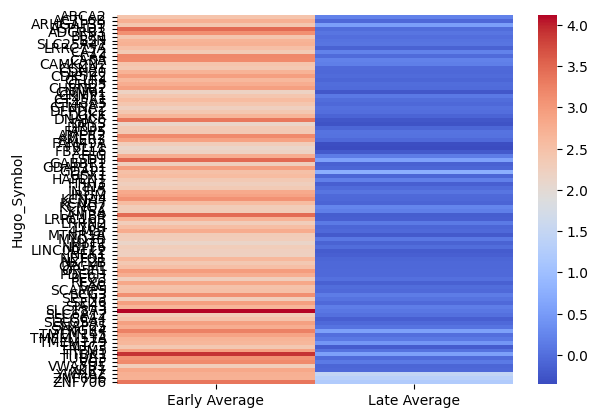

In [123]:
sns.heatmap(data_sorted.loc[cluster].drop(columns=["Cluster"]), cmap="coolwarm", xticklabels=True, yticklabels=True)


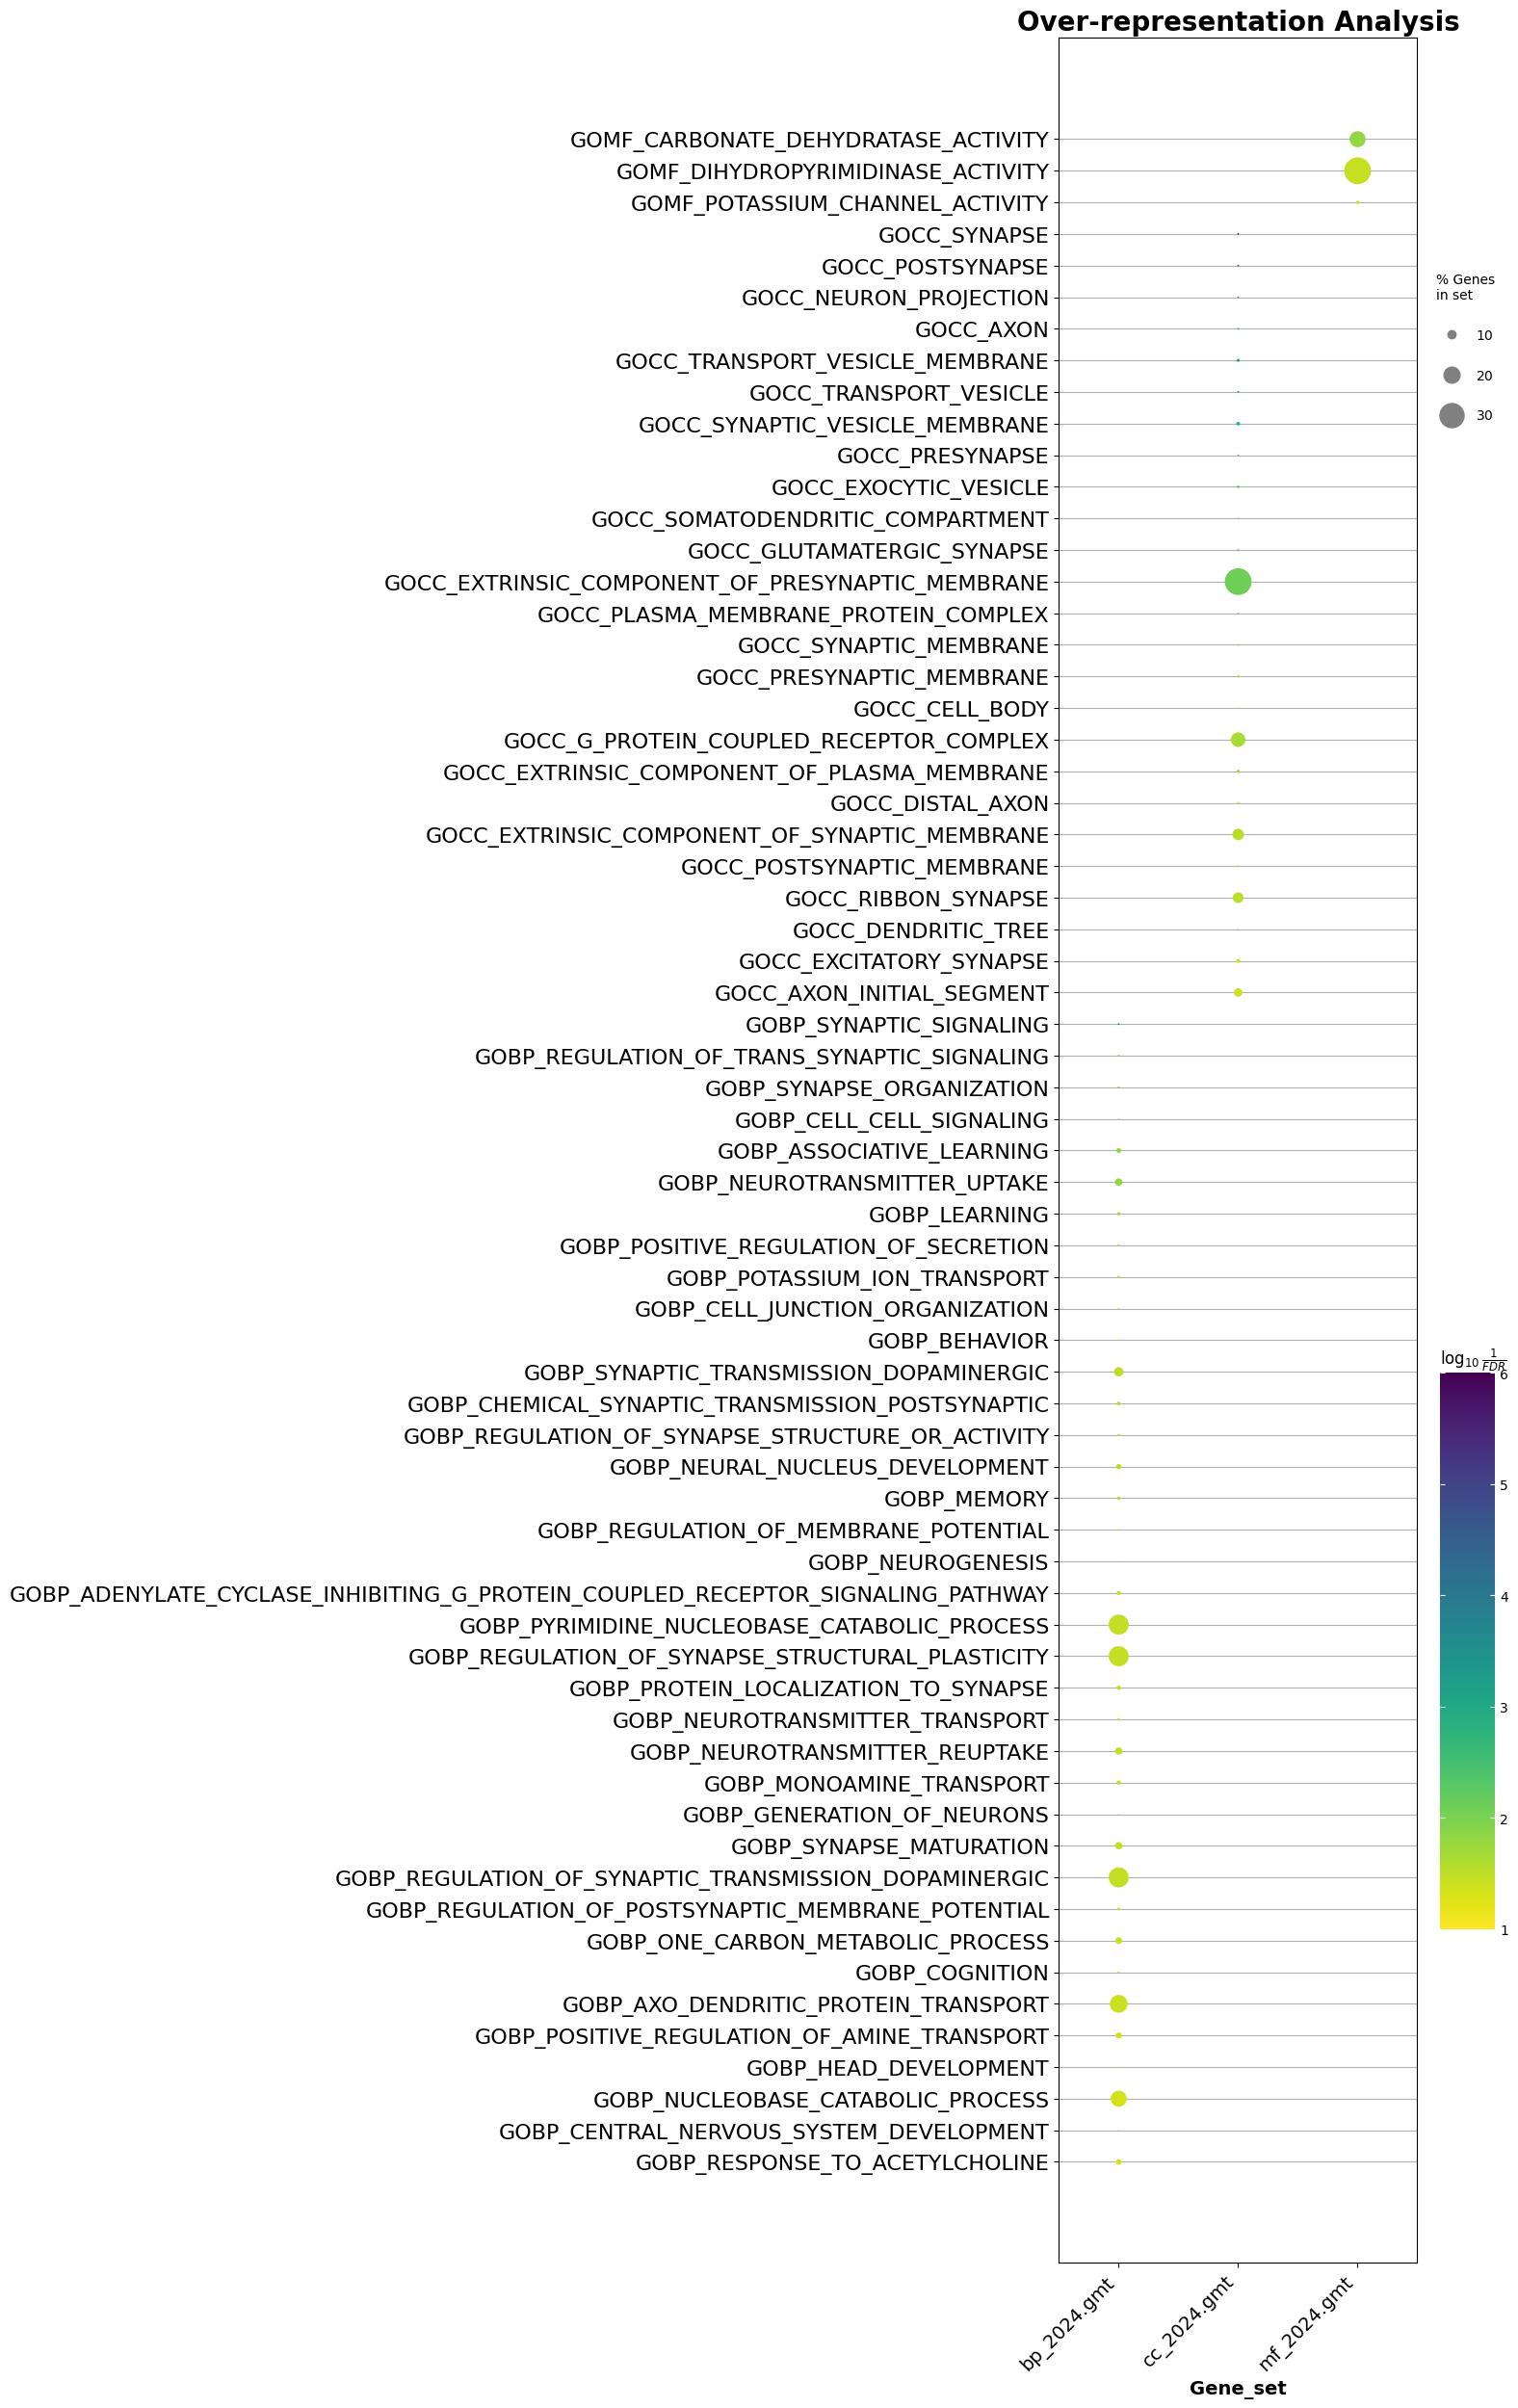

In [124]:
from gseapy import barplot, dotplot
ax = dotplot(enr.results,
              column="Adjusted P-value",
              x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
              size=10,
              top_term=70,
              figsize=(6,30),
              title = "Over-representation Analysis",
              xticklabels_rot=45, # rotate xtick labels
              show_ring=False, # set to False to revmove outer ring
              marker='o',
             )